# Practicioners Seminar

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

## Task 2

### A correlation heatmap for currencies and equity markets
Prepare data

In [2]:
# Read df
currencies = "Data/FX_CHF_ALL_1971-2020.xlsx"
msci_all_local = "Data/MSCI_ALL_LOCAL.xlsx"
interest_rates = "Data/3M_interest_rates.xlsx"
df_fx_indirect = pd.read_excel(currencies, header=0, index_col=0, sheet_name="Sheet1")
df_msci_local = pd.read_excel(msci_all_local, header=3, index_col=0, sheet_name="CleanTimeSeries")

# Direct FX rates
df_fx_direct = 1 / df_fx_indirect
df_fx_direct = df_fx_direct.replace([np.inf, -np.inf], np.nan)
df_fx_direct.columns = ['USDCHF', 'EURCHF', 'GBPCHF', 'AUDCHF', 'JPYCHF', 'CADCHF']


# Interest rates
df_r = pd.read_excel(interest_rates, header=1, index_col=0)
df_r.columns = ['CHF', 'USD', 'EUR', 'GBP', 'JPY', 'CAD', 'AUD']
df_r = df_r/100
df_r = df_r[df_r!=0].dropna()



In [3]:
# Function to get forward rates
def fx_forward(currency_pair, t, t_1):
    """Useage:
    date_1 = pd.Timestamp('2020-12-16')
    date_2 = pd.Timestamp('2020-12-18')
    fx_forward('USDCHF', date_1, date_2)
    """
    # Get spot exchange rate and LIBOR rates
    s = df_fx_direct.loc[t, currency_pair]
    r_d = df_r.loc[t, currency_pair[3:]]
    r_f = df_r.loc[t, currency_pair[:3]]
    
    # Calculate number of days
    n_days = t_1 - t
    n_days = n_days.days
    
    # Forward rate
    f = s * (1+r_d*n_days/365) / (1+r_f*n_days/365)
    
    return f
    

In [4]:
# Create a df with one period forward rates
df_f_daily = pd.DataFrame(index=df_r.index, columns=df_fx_direct.columns)
df_f_daily = df_f_daily.sort_index()
for d in range(len(df_f_daily.index)-1):
    for c in range(len(df_f_daily.columns)):
        try:
            df_f_daily.iloc[d, c] = fx_forward(df_f_daily.columns[c], df_f_daily.index[d], df_f_daily.index[d+1])
        except KeyError:
            df_f_daily.iloc[d, c] = np.nan

In [5]:
# FX Hedged MSCI Returns
df_msci_local_chf = df_msci_local.copy()
df_msci_local_chf = np.log(df_msci_local_chf.sort_index()).diff()

# Now they are USD hedged returns, change to CHF hedged returns

# MSCI World and US are denoted in USD
df_msci_local_chf['MSDLWI Index'] = df_msci_local_chf['MSDLWI Index'] * df_fx_direct['USDCHF'] / df_f_daily['USDCHF'].shift()
df_msci_local_chf['MXUS Index'] = df_msci_local_chf['MXUS Index'] * df_fx_direct['USDCHF'] / df_f_daily['USDCHF'].shift()

# MSCI Europe is denoted in EUR
df_msci_local_chf['MSDLE15 Index'] = df_msci_local_chf['MSDLE15 Index'] * df_fx_direct['EURCHF'] / df_f_daily['EURCHF'].shift()

# MSCI Australia is denoted in AUD
df_msci_local_chf['MSDLAS Index'] = df_msci_local_chf['MSDLAS Index'] * df_fx_direct['AUDCHF'] / df_f_daily['AUDCHF'].shift()

# MSCI Canada is denoted in CAD
df_msci_local_chf['MSDLCA Index'] = df_msci_local_chf['MSDLCA Index'] * df_fx_direct['CADCHF'] / df_f_daily['CADCHF'].shift()

# MSCI Japan is denoted in JPY
df_msci_local_chf['MSDLJN Index'] = df_msci_local_chf['MSDLJN Index'] * df_fx_direct['JPYCHF'] / df_f_daily['JPYCHF'].shift()

# MSCI UK is denoted in GBP
df_msci_local_chf['MSDLUK Index'] = df_msci_local_chf['MSDLUK Index'] * df_fx_direct['EURCHF'] / df_f_daily['EURCHF'].shift()

# Drop columns with NA
df_msci_local_chf = df_msci_local_chf[df_msci_local_chf!=0].dropna()
df_msci_local_chf = df_msci_local_chf.replace([np.inf, -np.inf], np.nan)

# Combine with FX rate data
df_fx_direct = np.log(df_fx_direct.sort_index()).diff()

# Combine the df
df_msci_fx_ret = pd.concat([df_msci_local_chf, df_fx_direct], axis=1, join="inner")

df_msci_fx_ret = df_msci_fx_ret[df_msci_fx_ret!=0].dropna()
df_msci_fx_ret


,MSDLSZ Index,MSDLWI Index,MSDLE15 Index,MSDLAS Index,MSDLCA Index,MSDLJN Index,MSDLUK Index,MXUS Index,USDCHF,EURCHF,GBPCHF,AUDCHF,JPYCHF,CADCHF
Date,,,,,,,,,,,,,,
2001-01-12,-0.004605,0.000820,0.009637,0.007808,-0.011506,0.003877,0.007149,-0.005533,0.003555,0.002768,-0.010104,0.001085,-0.002187,-0.001079
2001-01-16,0.000322,0.001086,-0.011785,-0.005290,-0.004366,0.014174,-0.012295,0.007456,-0.000981,-0.000770,-0.004579,0.002800,0.009805,-0.002933
2001-01-17,0.012626,0.008355,0.019868,0.003198,0.016904,0.007580,0.017629,0.000943,0.005733,-0.001538,0.006755,0.002627,-0.003464,0.002172
2001-01-18,-0.004065,0.008057,-0.001732,0.011305,0.005522,0.015026,0.002098,0.013176,-0.014030,-0.005670,-0.014181,0.001452,-0.007990,-0.015106
2001-01-19,-0.008520,-0.001270,-0.003347,0.007849,0.032300,0.002626,-0.001240,-0.003305,0.011077,0.001376,0.004066,-0.003898,0.018416,0.011741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-14,-0.002364,-0.001498,0.001907,0.003168,-0.009183,0.004011,-0.003010,-0.003059,-0.003287,-0.000862,0.004482,-0.003414,-0.003680,-0.002784
2020-12-15,-0.002760,0.008228,0.001326,-0.003994,0.005991,-0.004838,-0.003262,0.012648,-0.001507,-0.000646,0.008905,0.001806,0.002355,0.003481
2020-12-16,0.010991,0.003296,0.007623,0.007259,0.004417,0.002669,0.008792,0.001793,-0.000620,0.003127,0.002986,0.001742,0.001693,-0.003759


Correlation heatmap

<AxesSubplot:>

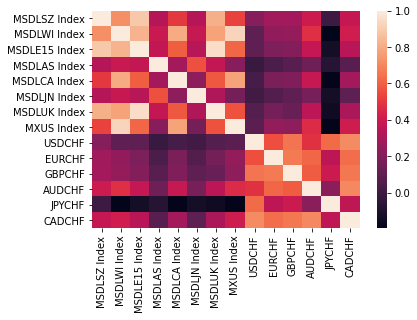

In [6]:
sns.heatmap(df_msci_fx_ret.corr(), xticklabels=df_msci_fx_ret.columns.values, yticklabels=df_msci_fx_ret.columns.values)

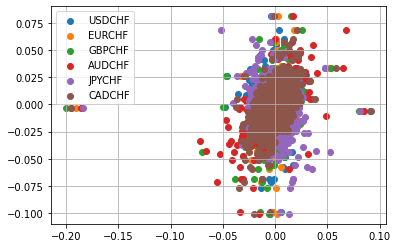

In [7]:
fig, ax = plt.subplots()
for currency in df_fx_direct.columns:
    ax.scatter(df_msci_fx_ret[currency], df_msci_fx_ret['MSDLWI Index'], label=currency)
ax.legend()
ax.grid(True)

<AxesSubplot:>

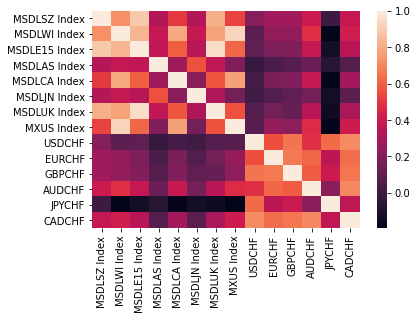

In [8]:
# Test if correlations are more clear if we remove the 15th January 2015, the day the pegging of the CHF was removed
df_msci_fx_ret_no_15January2015 = df_msci_fx_ret[df_msci_fx_ret['MSDLWI Index'] != df_msci_fx_ret['MSDLWI Index'].min()]
sns.heatmap(df_msci_fx_ret_no_15January2015.corr(), xticklabels=df_msci_fx_ret_no_15January2015.columns.values, yticklabels=df_msci_fx_ret_no_15January2015.columns.values)

Correlation MSCI World and FX rates

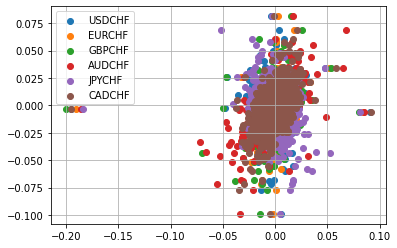

In [9]:
fig, ax = plt.subplots()
for currency in df_fx_direct.columns:
    ax.scatter(df_msci_fx_ret_no_15January2015[currency], df_msci_fx_ret_no_15January2015['MSDLWI Index'], label=currency)
ax.legend()
ax.grid(True)

/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


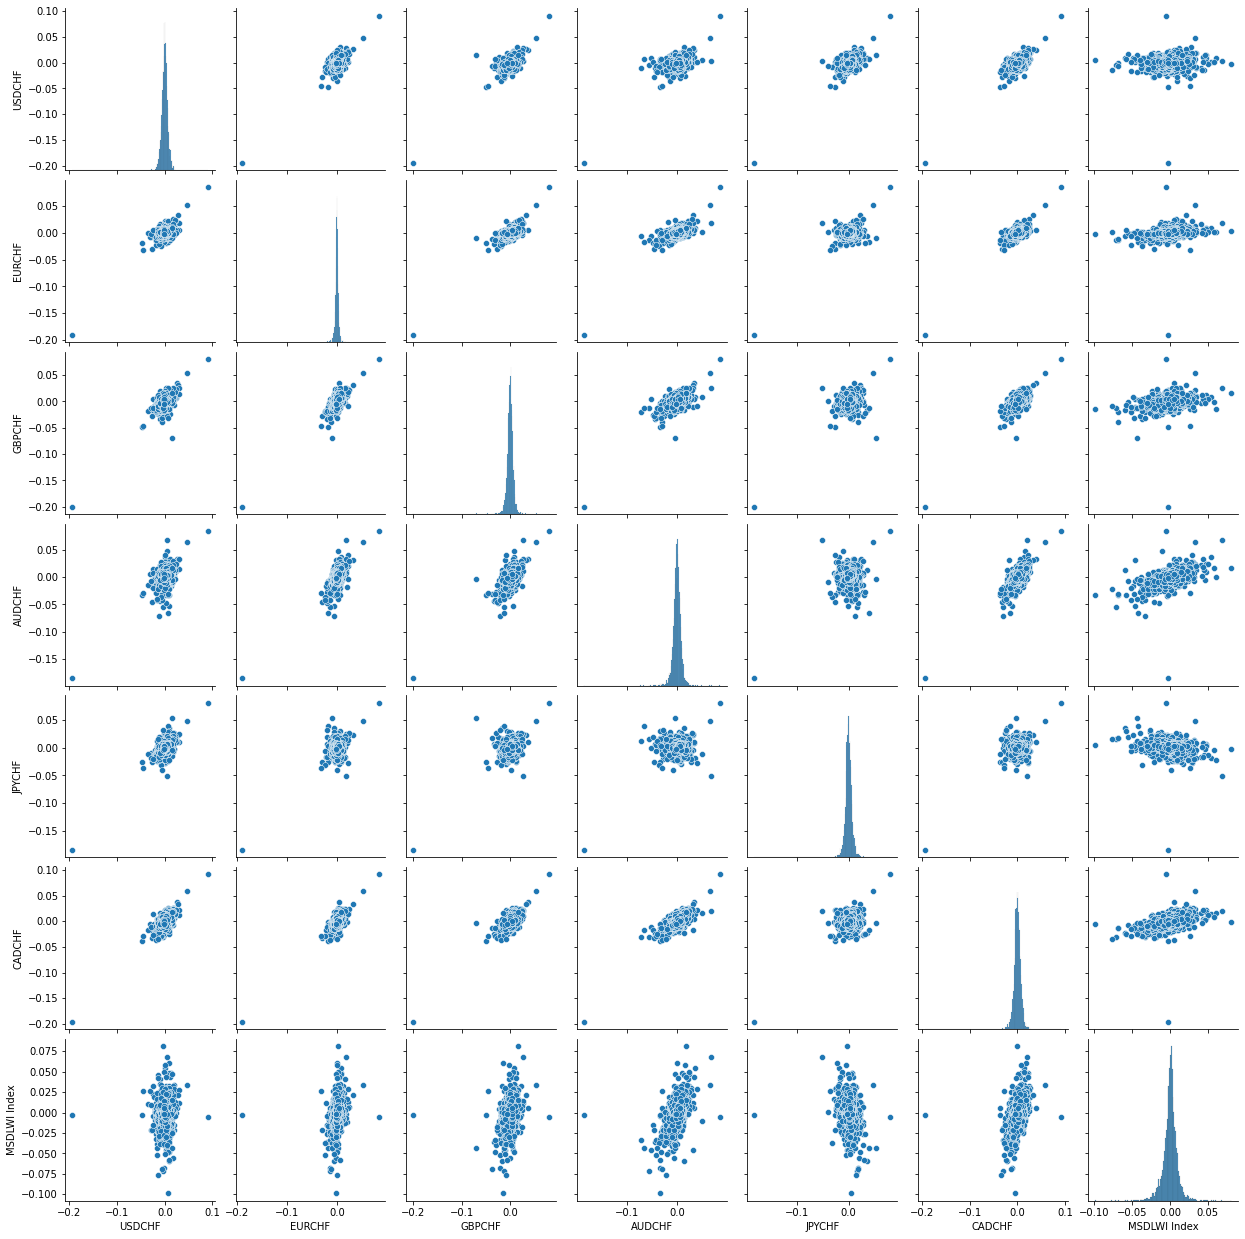

In [10]:
df_plot = df_msci_fx_ret_no_15January2015[df_fx_direct.columns]
df_plot.loc[:,'MSDLWI Index'] = df_msci_fx_ret_no_15January2015['MSDLWI Index']

sns.pairplot(df_plot)

In [11]:
df_plot.corr()

,USDCHF,EURCHF,GBPCHF,AUDCHF,JPYCHF,CADCHF,MSDLWI Index
USDCHF,1.000000,0.557867,0.650549,0.482203,0.627889,0.712046,0.094624
EURCHF,0.557867,1.000000,0.665388,0.615689,0.364846,0.632192,0.246381
GBPCHF,0.650549,0.665388,1.000000,0.591400,0.399190,0.659425,0.249867
AUDCHF,0.482203,0.615689,0.591400,1.000000,0.219666,0.702717,0.481549
JPYCHF,0.627889,0.364846,0.399190,0.219666,1.000000,0.369493,-0.192824
CADCHF,0.712046,0.632192,0.659425,0.702717,0.369493,1.000000,0.413902
MSDLWI Index,0.094624,0.246381,0.249867,0.481549,-0.192824,0.413902,1.000000


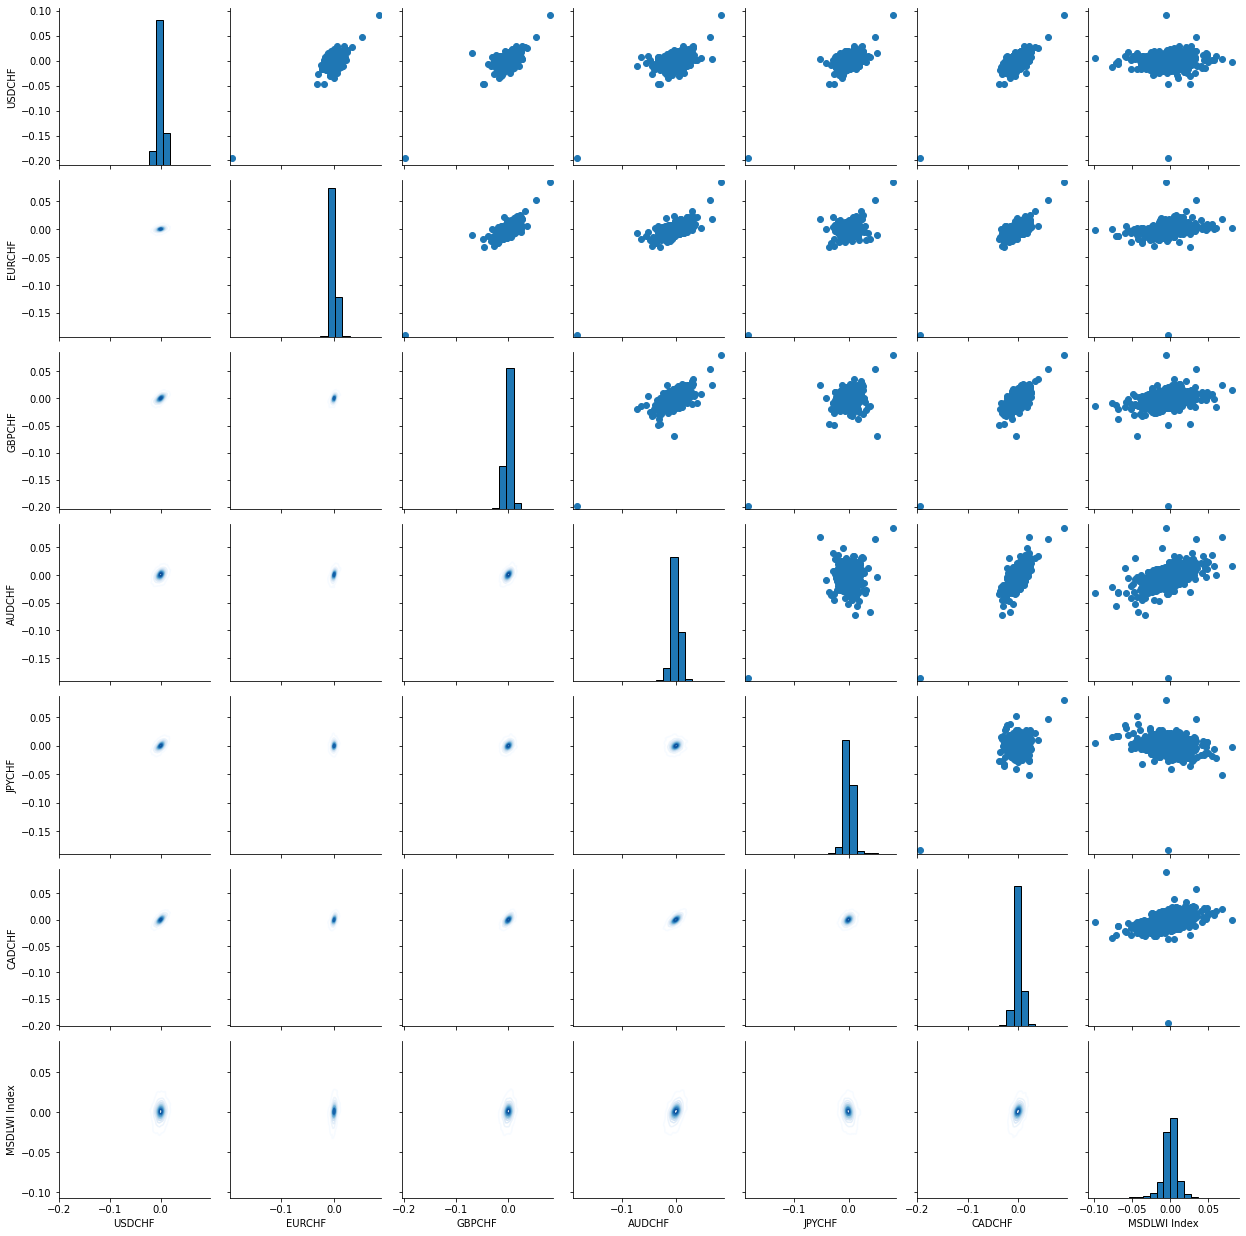

In [12]:
# Gridplot
grid = sns.PairGrid(data=df_plot)
grid = grid.map_upper(plt.scatter)
grid = grid.map_diag(plt.hist, bins = 20, 
                     edgecolor = 'k')
grid = grid.map_lower(sns.kdeplot, cmap = 'Blues')


### Same with monthly data

In [13]:
# Read df
currencies = "Data/FX_CHF_ALL_1971-2020.xlsx"
msci_all_local = "Data/MSCI_ALL_LOCAL_MONTHLY.xlsx"
interest_rates = "Data/3M_interest_rates.xlsx"
df_fx_indirect = pd.read_excel(currencies, header=0, index_col=0, sheet_name="Sheet1")
df_msci_local = pd.read_excel(msci_all_local, header=0, index_col=0)

# Direct FX rates
df_fx_direct = 1 / df_fx_indirect
df_fx_direct = df_fx_direct.replace([np.inf, -np.inf], np.nan)
df_fx_direct.columns = ['USDCHF', 'EURCHF', 'GBPCHF', 'AUDCHF', 'JPYCHF', 'CADCHF']
df_fx_direct = df_fx_direct.resample('M').last()

# Interest rates
df_r = pd.read_excel(interest_rates, header=1, index_col=0)
df_r.columns = ['CHF', 'USD', 'EUR', 'GBP', 'JPY', 'CAD', 'AUD']
df_r = df_r/100
df_r = df_r.resample('M').last()
df_r = df_r[df_r!=0].dropna()


In [14]:

# Create a df with one period forward rates
df_f = pd.DataFrame(index=df_msci_local.index, columns=df_fx_direct.columns)
df_f = df_f.sort_index()
for d in range(len(df_f.index)-1):
    for c in range(len(df_f.columns)):
        try:
            df_f.iloc[d, c] = fx_forward(df_f.columns[c], df_f.index[d], df_f.index[d+1])
        except KeyError:
            df_f.iloc[d, c] = np.nan



In [15]:
# FX Hedged MSCI Returns
df_msci_local_chf = df_msci_local.copy()
df_msci_local_chf = np.log(df_msci_local_chf.sort_index()).diff()

# Now they are USD hedged returns, change to CHF hedged returns

# MSCI World and US are denoted in USD
df_msci_local_chf['MSDLWI Index'] = df_msci_local_chf['MSDLWI Index'] * df_fx_direct['USDCHF'] / df_f['USDCHF'].shift()
df_msci_local_chf['MXUS Index'] = df_msci_local_chf['MXUS Index'] * df_fx_direct['USDCHF'] / df_f['USDCHF'].shift()

# MSCI Europe is denoted in EUR
df_msci_local_chf['MSDLE15 Index'] = df_msci_local_chf['MSDLE15 Index'] * df_fx_direct['EURCHF'] / df_f['EURCHF'].shift()

# MSCI Australia is denoted in AUD
df_msci_local_chf['MSDLAS Index'] = df_msci_local_chf['MSDLAS Index'] * df_fx_direct['AUDCHF'] / df_f['AUDCHF'].shift()

# MSCI Canada is denoted in CAD
df_msci_local_chf['MSDLCA Index'] = df_msci_local_chf['MSDLCA Index'] * df_fx_direct['CADCHF'] / df_f['CADCHF'].shift()

# MSCI Japan is denoted in JPY
df_msci_local_chf['MSDLJN Index'] = df_msci_local_chf['MSDLJN Index'] * df_fx_direct['JPYCHF'] / df_f['JPYCHF'].shift()

# MSCI UK is denoted in GBP
df_msci_local_chf['MSDLUK Index'] = df_msci_local_chf['MSDLUK Index'] * df_fx_direct['EURCHF'] / df_f['EURCHF'].shift()

# Drop columns with NA
df_msci_local_chf = df_msci_local_chf[df_msci_local_chf!=0].dropna()
df_msci_local_chf = df_msci_local_chf.replace([np.inf, -np.inf], np.nan)

# Combine with FX rate data
df_fx_direct_ret = np.log(df_fx_direct.sort_index()).diff()

# Combine the df
df_msci_fx_ret = pd.concat([df_msci_local_chf, df_fx_direct_ret], axis=1, join="inner")

df_msci_fx_ret = df_msci_fx_ret[df_msci_fx_ret!=0].dropna()

df_msci_fx_ret

,MSDLSZ Index,MSDLWI Index,MSDLE15 Index,MSDLAS Index,MSDLCA Index,MSDLJN Index,MSDLUK Index,MXUS Index,USDCHF,EURCHF,GBPCHF,AUDCHF,JPYCHF,CADCHF
Date,,,,,,,,,,,,,,
2001-02-28,-0.049703,-0.084673,-0.080496,-0.002574,-0.154434,-0.037874,-0.059276,-0.096978,0.019986,0.006914,0.006969,-0.023478,0.012995,-0.005879
2001-03-31,-0.076037,-0.052972,-0.048330,-0.043795,-0.070762,0.031781,-0.036270,-0.069905,0.043648,-0.009208,0.023915,-0.033234,-0.029834,0.017853
2001-04-30,0.025214,0.065896,0.063401,0.067900,0.044982,0.051915,0.053543,0.073799,-0.005735,0.007360,0.004952,0.029095,0.016418,0.021559
2001-05-31,0.019718,-0.009405,-0.021578,0.013216,0.024161,-0.044312,-0.028346,0.004659,0.036169,-0.012692,0.026662,0.037146,0.071968,0.034346
2001-06-30,-0.039297,-0.026628,-0.036238,0.025610,-0.060177,-0.012448,-0.026020,-0.023770,-0.002154,0.002891,-0.003816,0.002739,-0.047256,0.012702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.014438,0.058810,0.024911,0.017592,0.023228,0.075349,0.008092,0.070088,-0.010539,0.003446,0.011412,0.021889,-0.010983,0.017441
2020-09-30,0.004516,-0.031434,-0.010071,-0.042417,-0.027846,-0.002382,-0.016977,-0.040043,0.018793,0.000540,-0.015108,-0.010609,0.022908,-0.001799
2020-10-31,-0.059611,-0.031648,-0.055183,0.020189,-0.037625,-0.025790,-0.053383,-0.027318,-0.004319,-0.010522,-0.002377,-0.023144,0.003542,-0.004484


<AxesSubplot:>

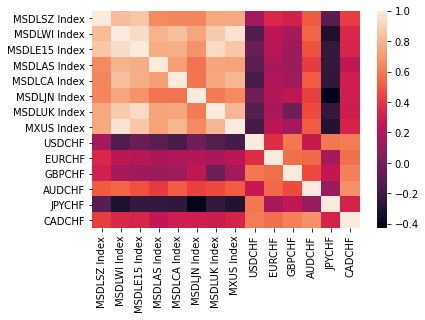

In [16]:
sns.heatmap(df_msci_fx_ret.corr(), xticklabels=df_msci_fx_ret.columns.values, yticklabels=df_msci_fx_ret.columns.values)

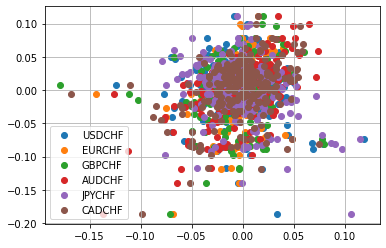

In [17]:
fig, ax = plt.subplots()
for currency in df_fx_direct.columns:
    ax.scatter(df_msci_fx_ret[currency], df_msci_fx_ret['MSDLWI Index'], label=currency)
ax.legend()
ax.grid(True)

/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


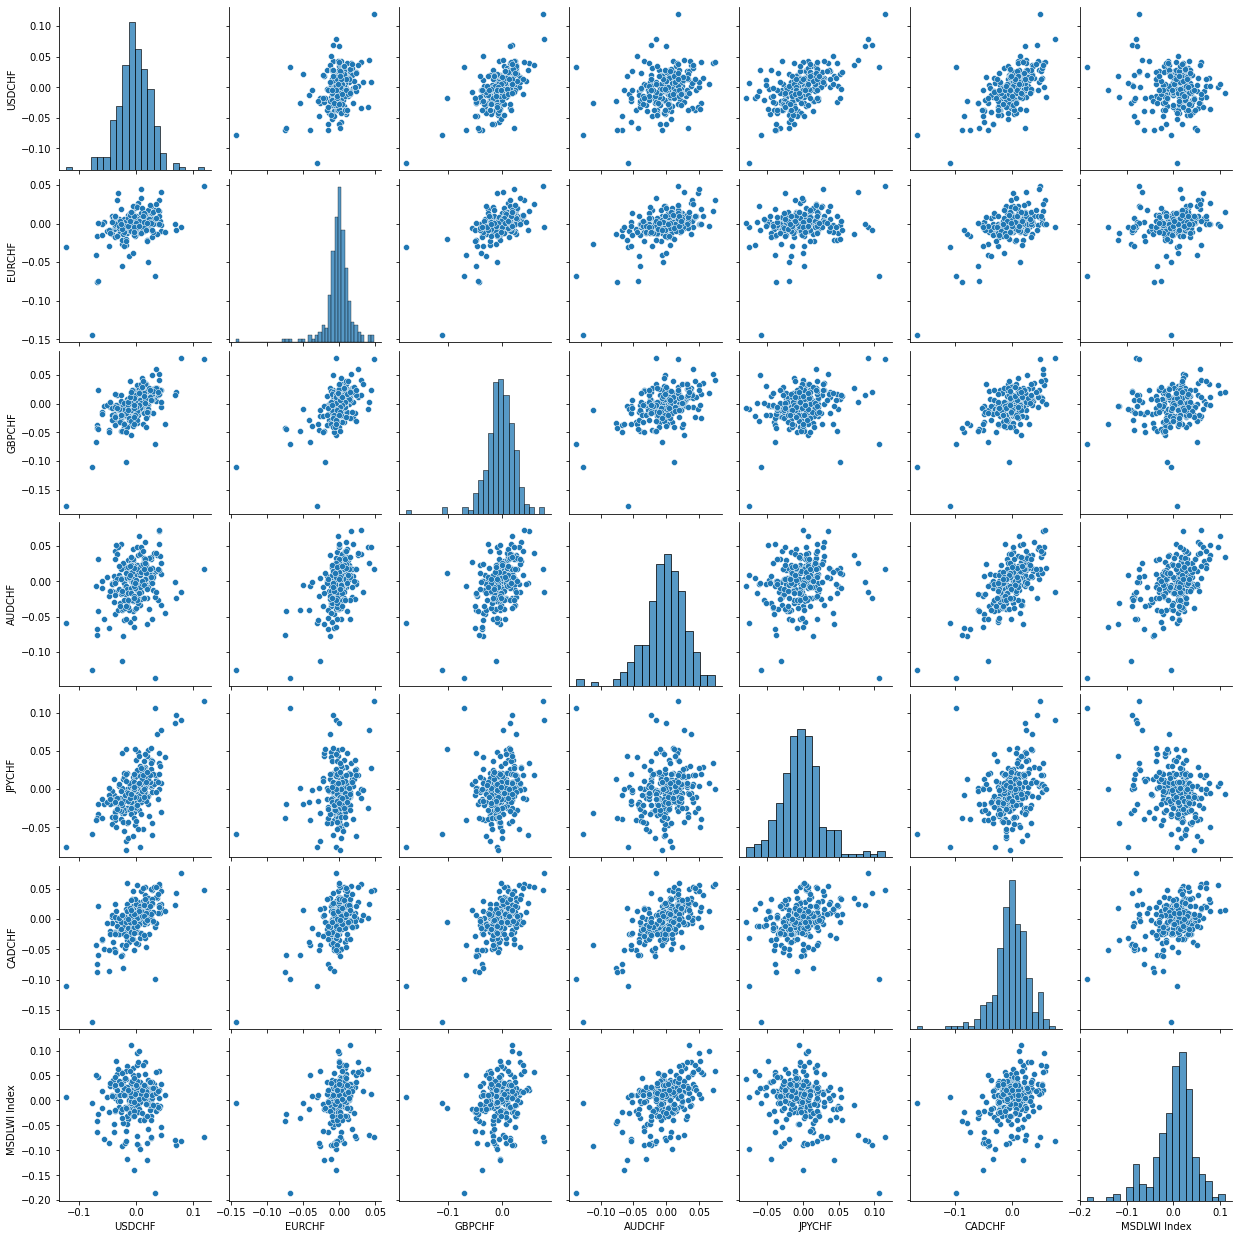

In [18]:
df_plot = df_msci_fx_ret[df_fx_direct.columns]
df_plot.loc[:,'MSDLWI Index'] = df_msci_fx_ret['MSDLWI Index']

sns.pairplot(df_plot)

In [19]:
df_plot.corr()

,USDCHF,EURCHF,GBPCHF,AUDCHF,JPYCHF,CADCHF,MSDLWI Index
USDCHF,1.000000,0.373793,0.597124,0.270888,0.597186,0.606487,-0.131071
EURCHF,0.373793,1.000000,0.569780,0.553501,0.160581,0.566535,0.241145
GBPCHF,0.597124,0.569780,1.000000,0.463737,0.255117,0.619039,0.163435
AUDCHF,0.270888,0.553501,0.463737,1.000000,0.116849,0.676518,0.533368
JPYCHF,0.597186,0.160581,0.255117,0.116849,1.000000,0.326955,-0.319157
CADCHF,0.606487,0.566535,0.619039,0.676518,0.326955,1.000000,0.344832
MSDLWI Index,-0.131071,0.241145,0.163435,0.533368,-0.319157,0.344832,1.000000


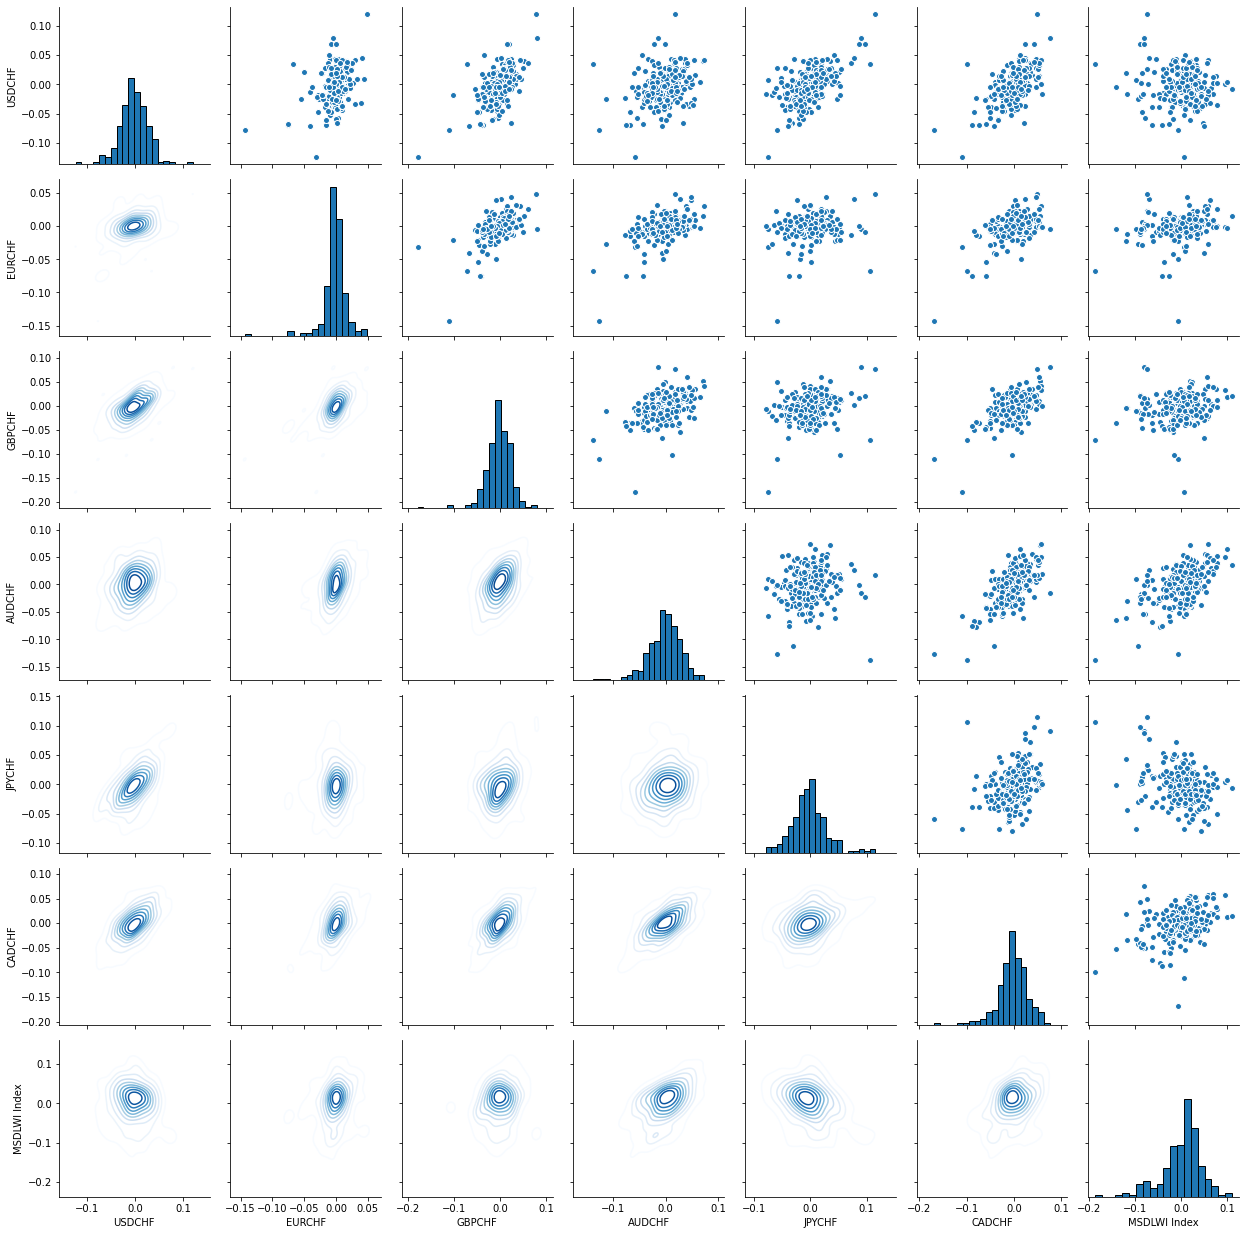

In [20]:
# sns.set(rc={'figure.facecolor':'black', 'axes.facecolor':'white'})
# Gridplot
grid = sns.PairGrid(data=df_plot)
grid = grid.map_upper(plt.scatter, edgecolor = 'white')
grid = grid.map_diag(plt.hist, bins = 20, 
                     edgecolor = 'k')
grid = grid.map_lower(sns.kdeplot, cmap = 'Blues')


In [21]:
grid.savefig('Plots/FX_MSCIWorld_PairCorrelation_Monthly.jpg')


# Code from below is old

In [ ]:
df_msci_local_chf


In [ ]:
currencies = "Data/FX_CHF_ALL_1971-2020.xlsx"
msci_all_local = "Data/MSCI_ALL_LOCAL.xlsx"
msci_all_usd_chf = "Data/MSCI_ALL_USD_CHF.xlsx"
df_currencies = pd.read_excel(currencies, header=0, index_col=0, sheet_name="Sheet1")
df_msci_all_local = pd.read_excel(msci_all_local, header=3, index_col=0, sheet_name="CleanTimeSeries")
df_msci_all_usd_chf = pd.read_excel(msci_all_usd_chf, header=3, index_col=0, sheet_name="CleanTimeSeries")

combined_df = pd.concat([df_currencies, df_msci_all_local], axis=1, join="inner")
combined_df_usd_chf = pd.concat([df_currencies, df_msci_all_usd_chf], axis=1, join="inner")

In [ ]:
combined_df

In [ ]:
return_cor = combined_df.corr()
sns.heatmap(return_cor, xticklabels=return_cor.columns.values, yticklabels=return_cor.columns.values)

In [ ]:
#combined_df.corr()

In [ ]:
z=combined_df
z = z[z!=0].dropna()
sns.heatmap(z.corr(), xticklabels=z.columns.values, yticklabels=z.columns.values)

In [ ]:
# Return df
return_df = np.log(combined_df.sort_index()).diff()
return_df = return_df[return_df!=0].dropna()
return_df

#### Heatmap local

In [ ]:
sns.heatmap(return_df.corr(), xticklabels=z.columns.values, yticklabels=z.columns.values)

Problem that MXUS is calculated with the USD method and not local as the others? Even though USD is the local currency of MXUS? 
Solved, found MXUS LOCAL on Refinitiv (only from 2001 onwards though)

#### Heatmap USD

In [ ]:
return_df_usd_chf = np.log(combined_df_usd_chf.sort_index()).diff()
return_df_usd_chf = return_df_usd_chf[return_df_usd_chf!=0].dropna()
sns.heatmap(return_df_usd_chf.corr(), xticklabels=z.columns.values, yticklabels=z.columns.values)

### Determine Hedge Ratios
#### Through regression
Need to find out which variables to take exactly for the regression, and what our hedge ratio then is!

In [ ]:
return_df_usd_chf

In [ ]:
# Define X and Y of regression (in case they are from different data frames)

# First remove spaces from column names
x_columns = return_df_usd_chf.columns
x_columns = [x.replace(' ', '') for x in x_columns]
return_df_usd_chf.columns = x_columns

y = return_df_usd_chf['MXWOIndex']
x_columns = return_df_usd_chf.columns
x_columns = x_columns.drop('MXWOIndex')
x = return_df_usd_chf[x_columns]

# Create common df
reg_df = pd.concat([y, x], axis=1, join="inner")

In [ ]:
# Multivariate regression
formula = "MXWOIndex ~ CHFUSD + CHFEUR + CHFGBP + CHFAUD + CHFJPY + CHFCAD + MSDUSZIndex + MSDUE15Index + MSDUASIndex + MSDUCAIndex + MSDUJNIndex + MSDUUKIndex + MXUSIndex"
factor_model = ols(formula, data = reg_df)
factor_model = factor_model.fit()
factor_model.summary()

#### Portfolio optimization approach
Probably need to change to black litterman approach with market implied expected returns. For currency pairs the market implied expected returns should be given by interest rate differentials. Also how is the hedge done? Probably not by keeping part of portfolio in foreign currency cash! If its done through forwards, we need to take some margin assumptions!

In [ ]:
# Portfolio components
portfolio_chf_components = return_df_usd_chf[['MXWOIndex', 'CHFUSD', 'CHFEUR', 'CHFGBP', 'CHFAUD', 'CHFJPY', 'CHFCAD']]

# Prepare covariance matrix and expected return vector
risk_free_rate = pd.read_excel('Data/3M_interest_rates.xlsx', index_col=0, header=1)
risk_free_rate_chf = risk_free_rate['SF0003M  Index']

# For MSCI World denominated in CHF subtract 3 CHF risk free interest rate to get excess returns?
portfolio_chf_excess_returns = portfolio_chf_components

# Change annualized risk free rate to a continuous daily rate in %
risk_free_rate_chf = pow(risk_free_rate_chf/100 + 1, 1/252) - 1

# Subtract the daily risk free rate from MSCI World returns
portfolio_chf_excess_returns.loc[: ,'MXWOIndex'] = portfolio_chf_excess_returns['MXWOIndex'] - risk_free_rate_chf[risk_free_rate_chf.index.isin(portfolio_chf_excess_returns.index)]
portfolio_chf_excess_returns = portfolio_chf_excess_returns[portfolio_chf_excess_returns!=0].dropna()

portfolio_covar = portfolio_chf_excess_returns.cov()
portfolio_expected_return = portfolio_chf_excess_returns.mean()

# Note that MSCI World performance was actually quiet bad for CHF investor since 2000 (see plot)
combined_df_usd_chf['MXWO Index'].plot()
combined_df['MSDLWI Index'].plot()



In [ ]:
# Calculate optimal weights
numerator = np.dot(np.linalg.inv(portfolio_covar), portfolio_expected_return) 
denumerator = np.dot(np.dot(np.ones(len(portfolio_expected_return)), np.linalg.inv(portfolio_covar)), portfolio_expected_return)

optimal_weights = pd.Series(numerator / denumerator, index = portfolio_expected_return.index)
optimal_weights